# Phase 2a: Training Interpretable Transformer (Self-Contained Colab Version)

This notebook contains everything inline - no file uploads needed!

**Run cells in order. Training takes ~30-60 min on Colab GPU.**

In [1]:
# Check GPU
!nvidia-smi

Thu Nov 27 06:47:31 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             45W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

## Cell 1: All Imports and Class Definitions

This cell defines the Tokenizer, Dataset, and Model classes.

In [2]:
#@title Run this cell first - Defines all classes { display-mode: "form" }

import json
import math
import random
from typing import List, Dict, Optional, Tuple, Any
from dataclasses import dataclass, field
from collections import deque

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR

import matplotlib.pyplot as plt
from IPython.display import clear_output
import re

# ============================================================================
# TOKENIZER
# ============================================================================

class SymbolicOntologyTokenizer:
    """Tokenizer for symbolic ontology notation."""
    
    PAD_TOKEN = "<PAD>"
    BOS_TOKEN = "<BOS>"
    EOS_TOKEN = "<EOS>"
    UNK_TOKEN = "<UNK>"
    WORLD_MODEL_TOKEN = "[WORLD_MODEL]"
    OBSERVATIONS_TOKEN = "[OBSERVATIONS]"
    TASK_TOKEN = "[TASK]"
    ANSWER_TOKEN = "[ANSWER]"
    FORALL_TOKEN = "∀x:"
    IMPLIES_TOKEN = "->"
    OPEN_PAREN = "("
    CLOSE_PAREN = ")"
    PRED_X = "(x)"
    
    def __init__(self, max_concepts=30, max_properties=15, max_entities=30, max_seq_len=512):
        self.max_concepts = max_concepts
        self.max_properties = max_properties
        self.max_entities = max_entities
        self.max_seq_len = max_seq_len
        self._build_vocab()
        
    def _build_vocab(self):
        self.token_to_id = {}
        self.id_to_token = {}
        current_id = 0
        
        for token in [self.PAD_TOKEN, self.BOS_TOKEN, self.EOS_TOKEN, self.UNK_TOKEN]:
            self.token_to_id[token] = current_id
            self.id_to_token[current_id] = token
            current_id += 1
        
        for token in [self.WORLD_MODEL_TOKEN, self.OBSERVATIONS_TOKEN, 
                      self.TASK_TOKEN, self.ANSWER_TOKEN]:
            self.token_to_id[token] = current_id
            self.id_to_token[current_id] = token
            current_id += 1
        
        for token in [self.FORALL_TOKEN, self.IMPLIES_TOKEN, 
                      self.OPEN_PAREN, self.CLOSE_PAREN, self.PRED_X]:
            self.token_to_id[token] = current_id
            self.id_to_token[current_id] = token
            current_id += 1
        
        self.token_to_id["\n"] = current_id
        self.id_to_token[current_id] = "\n"
        current_id += 1
        
        for i in range(self.max_concepts):
            token = f"c{i}"
            self.token_to_id[token] = current_id
            self.id_to_token[current_id] = token
            current_id += 1
        
        for i in range(1, self.max_properties + 1):
            token = f"p{i}"
            self.token_to_id[token] = current_id
            self.id_to_token[current_id] = token
            current_id += 1
        
        for i in range(self.max_entities):
            token = f"e{i}"
            self.token_to_id[token] = current_id
            self.id_to_token[current_id] = token
            current_id += 1
        
        self.vocab_size = current_id
        self.pad_token_id = self.token_to_id[self.PAD_TOKEN]
        self.bos_token_id = self.token_to_id[self.BOS_TOKEN]
        self.eos_token_id = self.token_to_id[self.EOS_TOKEN]
        self.unk_token_id = self.token_to_id[self.UNK_TOKEN]
    
    def _tokenize_statement(self, statement):
        statement = statement.strip()
        tokens = []
        
        if statement.startswith("∀x:"):
            tokens.append(self.FORALL_TOKEN)
            statement = statement[3:].strip()
        
        if "->" in statement:
            parts = statement.split("->")
            left = parts[0].strip()
            left_match = re.match(r'([cp]\d+)\(x\)', left)
            if left_match:
                tokens.append(left_match.group(1))
                tokens.append(self.PRED_X)
            tokens.append(self.IMPLIES_TOKEN)
            right = parts[1].strip()
            right_match = re.match(r'([cp]\d+)\(x\)', right)
            if right_match:
                tokens.append(right_match.group(1))
                tokens.append(self.PRED_X)
        else:
            match = re.match(r'([cp]\d+)\(([e]\d+)\)', statement)
            if match:
                tokens.append(match.group(1))
                tokens.append(self.OPEN_PAREN)
                tokens.append(match.group(2))
                tokens.append(self.CLOSE_PAREN)
        return tokens
    
    def tokenize(self, text, add_special_tokens=True):
        tokens = []
        if add_special_tokens:
            tokens.append(self.BOS_TOKEN)
        
        lines = text.strip().split('\n')
        for line in lines:
            line = line.strip()
            if not line:
                continue
            if line == "[WORLD_MODEL]":
                tokens.append(self.WORLD_MODEL_TOKEN)
                tokens.append("\n")
            elif line == "[OBSERVATIONS]":
                tokens.append(self.OBSERVATIONS_TOKEN)
                tokens.append("\n")
            elif line == "[TASK]":
                tokens.append(self.TASK_TOKEN)
                tokens.append("\n")
            elif line == "[ANSWER]":
                tokens.append(self.ANSWER_TOKEN)
                tokens.append("\n")
            elif line.startswith("Infer"):
                continue
            else:
                stmt_tokens = self._tokenize_statement(line)
                tokens.extend(stmt_tokens)
                tokens.append("\n")
        
        if add_special_tokens:
            tokens.append(self.EOS_TOKEN)
        return tokens
    
    def encode(self, text, add_special_tokens=True):
        tokens = self.tokenize(text, add_special_tokens)
        return [self.token_to_id.get(t, self.unk_token_id) for t in tokens]
    
    def decode(self, token_ids, skip_special_tokens=True):
        special_ids = {self.pad_token_id, self.bos_token_id, self.eos_token_id}
        tokens = []
        for tid in token_ids:
            if skip_special_tokens and tid in special_ids:
                continue
            tokens.append(self.id_to_token.get(tid, self.UNK_TOKEN))
        return "".join(tokens)

# ============================================================================
# DATA GENERATOR (inline, no file needed)
# ============================================================================

@dataclass
class OntologyNode:
    concept_id: int
    depth: int
    parent_id: Optional[int] = None
    children_ids: List[int] = field(default_factory=list)
    properties: List[int] = field(default_factory=list)
    members: List[int] = field(default_factory=list)

class SymbolicOntologyGenerator:
    def __init__(self, depth=3, branching_factor=2, num_properties=5, 
                 property_assignment_prob=0.4, members_per_leaf=2, seed=None):
        self.depth = depth
        self.branching_factor = branching_factor
        self.num_properties = num_properties
        self.property_assignment_prob = property_assignment_prob
        self.members_per_leaf = members_per_leaf
        if seed is not None:
            random.seed(seed)
        self.nodes = {}
        self.num_concepts = 0
        self.num_members = 0
        self._generate_structure()
    
    def _generate_structure(self):
        root = OntologyNode(concept_id=0, depth=0)
        self.nodes[0] = root
        self.num_concepts = 1
        queue = deque([0])
        
        while queue:
            node_id = queue.popleft()
            node = self.nodes[node_id]
            if node.depth >= self.depth:
                continue
            for _ in range(self.branching_factor):
                child_id = self.num_concepts
                child = OntologyNode(concept_id=child_id, depth=node.depth + 1, parent_id=node_id)
                self.nodes[child_id] = child
                node.children_ids.append(child_id)
                self.num_concepts += 1
                queue.append(child_id)
        
        for node_id, node in self.nodes.items():
            for prop_id in range(1, self.num_properties + 1):
                if random.random() < self.property_assignment_prob:
                    node.properties.append(prop_id)
        
        for node_id, node in self.nodes.items():
            if not node.children_ids:
                for _ in range(self.members_per_leaf):
                    node.members.append(self.num_members)
                    self.num_members += 1
    
    def get_ancestors(self, node_id):
        ancestors = []
        current = node_id
        while self.nodes[current].parent_id is not None:
            current = self.nodes[current].parent_id
            ancestors.append(current)
        return ancestors
    
    def get_inherited_properties(self, node_id):
        props = set(self.nodes[node_id].properties)
        for anc_id in self.get_ancestors(node_id):
            props.update(self.nodes[anc_id].properties)
        return props
    
    def generate_world_model_text(self):
        lines = []
        for node_id, node in self.nodes.items():
            if node.parent_id is not None:
                lines.append(f"∀x: c{node_id}(x) -> c{node.parent_id}(x)")
        for node_id, node in self.nodes.items():
            for member_id in node.members:
                lines.append(f"c{node_id}(e{member_id})")
        return lines

def generate_inductive_sample(gen, hide_at_depth=None):
    candidates = []
    for node_id, node in gen.nodes.items():
        if node.properties and node.children_ids:
            if hide_at_depth is None or node.depth == hide_at_depth:
                candidates.append(node_id)
    
    if not candidates:
        for node_id, node in gen.nodes.items():
            if node.properties:
                candidates.append(node_id)
    
    if not candidates:
        return None
    
    target_node_id = random.choice(candidates)
    target_node = gen.nodes[target_node_id]
    hidden_property = random.choice(target_node.properties)
    
    world_model_lines = []
    for node_id, node in gen.nodes.items():
        if node.parent_id is not None:
            world_model_lines.append(f"∀x: c{node_id}(x) -> c{node.parent_id}(x)")
    for node_id, node in gen.nodes.items():
        for member_id in node.members:
            world_model_lines.append(f"c{node_id}(e{member_id})")
    for node_id, node in gen.nodes.items():
        for prop_id in node.properties:
            if not (node_id == target_node_id and prop_id == hidden_property):
                world_model_lines.append(f"∀x: c{node_id}(x) -> p{prop_id}(x)")
    
    def get_all_members_under(nid):
        members = list(gen.nodes[nid].members)
        for child_id in gen.nodes[nid].children_ids:
            members.extend(get_all_members_under(child_id))
        return members
    
    all_members = get_all_members_under(target_node_id)
    observations = [f"p{hidden_property}(e{m})" for m in all_members]
    
    if not observations:
        return None
    
    target = f"∀x: c{target_node_id}(x) -> p{hidden_property}(x)"
    
    input_text = "[WORLD_MODEL]\n" + "\n".join(world_model_lines)
    input_text += "\n[OBSERVATIONS]\n" + "\n".join(observations)
    input_text += "\n[TASK]\nInfer the most general rule."
    
    return {
        "input": input_text,
        "target": target,
        "task_type": "inductive",
        "metadata": {
            "depth_of_truth": target_node.depth,
            "tree_depth": gen.depth,
            "hidden_property": hidden_property,
            "target_concept": target_node_id,
            "num_observations": len(observations)
        }
    }

def generate_dataset(num_samples, min_depth=2, max_depth=4, seed=42):
    random.seed(seed)
    samples = []
    for i in range(num_samples):
        depth = random.randint(min_depth, max_depth)
        branch = random.randint(2, 3)
        gen = SymbolicOntologyGenerator(
            depth=depth, branching_factor=branch,
            num_properties=5, property_assignment_prob=0.5,
            members_per_leaf=2, seed=None
        )
        sample = generate_inductive_sample(gen)
        if sample:
            sample["id"] = i
            samples.append(sample)
    return samples

# ============================================================================
# DATASET CLASS
# ============================================================================

class SymbolicOntologyDataset(Dataset):
    def __init__(self, samples, tokenizer, max_input_len=512, max_target_len=32):
        self.samples = samples
        self.tokenizer = tokenizer
        self.max_input_len = max_input_len
        self.max_target_len = max_target_len
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        input_ids = self.tokenizer.encode(sample["input"], add_special_tokens=True)
        target_ids = self.tokenizer.encode(sample["target"], add_special_tokens=False)
        target_ids = target_ids + [self.tokenizer.eos_token_id]
        
        answer_token_id = self.tokenizer.token_to_id[self.tokenizer.ANSWER_TOKEN]
        newline_id = self.tokenizer.token_to_id["\n"]
        
        if input_ids[-1] == self.tokenizer.eos_token_id:
            input_ids = input_ids[:-1]
        
        max_input_tokens = self.max_input_len - 2
        if len(input_ids) > max_input_tokens:
            input_ids = input_ids[:max_input_tokens]
        if len(target_ids) > self.max_target_len:
            target_ids = target_ids[:self.max_target_len]
        
        full_ids = input_ids + [answer_token_id, newline_id] + target_ids
        max_len = self.max_input_len + self.max_target_len
        
        if len(full_ids) > max_len:
            full_ids = full_ids[:max_len]
        
        target_start = len(input_ids) + 2
        attention_mask = [1] * len(full_ids)
        padding_len = max_len - len(full_ids)
        full_ids = full_ids + [self.tokenizer.pad_token_id] * padding_len
        attention_mask = attention_mask + [0] * padding_len
        
        labels = full_ids.copy()
        labels[:target_start] = [-100] * target_start
        
        return {
            "input_ids": torch.tensor(full_ids, dtype=torch.long),
            "labels": torch.tensor(labels, dtype=torch.long),
            "attention_mask": torch.tensor(attention_mask, dtype=torch.long),
        }

# ============================================================================
# MODEL
# ============================================================================

@dataclass
class TransformerConfig:
    vocab_size: int = 100
    max_seq_len: int = 512
    n_layers: int = 4
    n_heads: int = 1
    d_model: int = 64
    d_ff: int = 256
    dropout: float = 0.0
    pad_token_id: int = 0
    concat_pos_emb: bool = True
    pre_ln: bool = True
    causal: bool = True
    use_ff: bool = True
    
    @property
    def embedding_dim(self):
        if self.concat_pos_emb:
            return self.d_model + self.max_seq_len
        return self.d_model

class SingleHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        input_dim = config.embedding_dim
        self.proj_q = nn.Linear(input_dim, config.d_model, bias=True)
        self.proj_k = nn.Linear(input_dim, config.d_model, bias=True)
        self.proj_v = nn.Linear(input_dim, config.d_model, bias=True)
        self.proj_out = nn.Linear(config.d_model, input_dim, bias=True)
        self.dropout = nn.Dropout(config.dropout)
        self.scale = math.sqrt(config.d_model)
        
    def forward(self, x, attention_mask=None, return_attention=False):
        batch_size, seq_len, _ = x.shape
        Q = self.proj_q(x)
        K = self.proj_k(x)
        V = self.proj_v(x)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale
        
        if self.config.causal:
            causal_mask = torch.triu(torch.ones(seq_len, seq_len, device=x.device, dtype=torch.bool), diagonal=1)
            scores = scores.masked_fill(causal_mask, float('-inf'))
        
        if attention_mask is not None:
            padding_mask = (attention_mask == 0).unsqueeze(1)
            scores = scores.masked_fill(padding_mask, float('-inf'))
        
        attention_weights = F.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)
        output = torch.matmul(attention_weights, V)
        output = self.proj_out(output)
        
        if return_attention:
            return output, attention_weights
        return output, None

class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        input_dim = config.embedding_dim
        self.fc1 = nn.Linear(input_dim, config.d_ff)
        self.fc2 = nn.Linear(config.d_ff, input_dim)
        self.dropout = nn.Dropout(config.dropout)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.ln_attn = nn.LayerNorm(config.embedding_dim)
        self.attn = SingleHeadAttention(config)
        if config.use_ff:
            self.ln_ff = nn.LayerNorm(config.embedding_dim)
            self.ff = FeedForward(config)
        else:
            self.ln_ff = None
            self.ff = None
        self.dropout = nn.Dropout(config.dropout)
        
    def forward(self, x, attention_mask=None, return_attention=False):
        if self.config.pre_ln:
            attn_out, attn_weights = self.attn(self.ln_attn(x), attention_mask, return_attention)
            x = x + self.dropout(attn_out)
            if self.ff is not None:
                x = x + self.dropout(self.ff(self.ln_ff(x)))
        else:
            attn_out, attn_weights = self.attn(x, attention_mask, return_attention)
            x = self.ln_attn(x + self.dropout(attn_out))
            if self.ff is not None:
                x = self.ln_ff(x + self.dropout(self.ff(x)))
        return x, attn_weights

class InterpretableTransformer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.token_embedding = nn.Embedding(config.vocab_size, config.d_model, padding_idx=config.pad_token_id)
        
        if config.concat_pos_emb:
            self.register_buffer('position_embedding', torch.eye(config.max_seq_len))
        else:
            self.position_embedding = nn.Embedding(config.max_seq_len, config.d_model)
        
        self.dropout_embedding = nn.Dropout(config.dropout)
        self.layers = nn.ModuleList([TransformerBlock(config) for _ in range(config.n_layers)])
        self.ln_final = nn.LayerNorm(config.embedding_dim)
        self.lm_head = nn.Linear(config.embedding_dim, config.vocab_size, bias=False)
        self._init_weights()
        
    def _init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0.0, std=0.02)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
            elif isinstance(module, nn.Embedding):
                nn.init.normal_(module.weight, mean=0.0, std=0.02)
                if module.padding_idx is not None:
                    module.weight.data[module.padding_idx].zero_()
    
    def get_embeddings(self, input_ids):
        batch_size, seq_len = input_ids.shape
        token_emb = self.token_embedding(input_ids)
        
        if self.config.concat_pos_emb:
            pos_emb = self.position_embedding[:seq_len, :seq_len]
            pos_emb = pos_emb.unsqueeze(0).expand(batch_size, -1, -1)
            embeddings = torch.cat([token_emb, pos_emb], dim=-1)
        else:
            positions = torch.arange(seq_len, device=input_ids.device)
            pos_emb = self.position_embedding(positions)
            embeddings = token_emb + pos_emb
        
        return self.dropout_embedding(embeddings)
    
    def forward(self, input_ids, attention_mask=None, return_hidden_states=False, return_attention=False):
        x = self.get_embeddings(input_ids)
        hidden_states = [x] if return_hidden_states else None
        attentions = [] if return_attention else None
        
        for layer in self.layers:
            x, attn_weights = layer(x, attention_mask, return_attention)
            if return_hidden_states:
                hidden_states.append(x)
            if return_attention:
                attentions.append(attn_weights)
        
        x = self.ln_final(x)
        logits = self.lm_head(x)
        
        output = {"logits": logits}
        if return_hidden_states:
            output["hidden_states"] = hidden_states
        if return_attention:
            output["attentions"] = attentions
        return output
    
    def generate(self, input_ids, max_new_tokens=32, temperature=1.0, do_sample=False):
        self.eval()
        with torch.no_grad():
            for _ in range(max_new_tokens):
                outputs = self(input_ids)
                logits = outputs["logits"][:, -1, :]
                if do_sample:
                    probs = F.softmax(logits / temperature, dim=-1)
                    next_token = torch.multinomial(probs, num_samples=1)
                else:
                    next_token = logits.argmax(dim=-1, keepdim=True)
                input_ids = torch.cat([input_ids, next_token], dim=-1)
                if (next_token == 2).all():
                    break
        return input_ids

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("✓ All classes defined!")

✓ All classes defined!


## Cell 2: Configuration

In [6]:
#@title Training Configuration { display-mode: "form" }

#@markdown ### Data
NUM_TRAIN_SAMPLES = 1600  #@param {type:"integer"}
NUM_VAL_SAMPLES = 400  #@param {type:"integer"}
MIN_DEPTH = 2  #@param {type:"integer"}
MAX_DEPTH = 4  #@param {type:"integer"}

#@markdown ### Model
N_LAYERS = 4  #@param {type:"integer"}
N_HEADS = 1  #@param {type:"integer"}
D_MODEL = 64  #@param {type:"integer"}
D_FF = 256  #@param {type:"integer"}

#@markdown ### Training
BATCH_SIZE = 32  #@param {type:"integer"}
LEARNING_RATE = 1e-3  #@param {type:"number"}
NUM_EPOCHS = 1000  #@param {type:"integer"}
GRAD_CLIP = 1.0  #@param {type:"number"}

#@markdown ### Logging
EVAL_INTERVAL = 50  #@param {type:"integer"}
PLOT_INTERVAL = 100  #@param {type:"integer"}

# Derived
MAX_INPUT_LEN = 512
MAX_TARGET_LEN = 32
MAX_SEQ_LEN = MAX_INPUT_LEN + MAX_TARGET_LEN

# Device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {DEVICE}")

# Seed
torch.manual_seed(42)
random.seed(42)

Using device: cuda


## Cell 3: Generate Data and Initialize Model

In [7]:
print("Generating training data...")
train_samples = generate_dataset(NUM_TRAIN_SAMPLES, MIN_DEPTH, MAX_DEPTH, seed=42)
print(f"Generated {len(train_samples)} training samples")

print("Generating validation data...")
val_samples = generate_dataset(NUM_VAL_SAMPLES, MIN_DEPTH, MAX_DEPTH, seed=123)
print(f"Generated {len(val_samples)} validation samples")

# Create tokenizer
tokenizer = SymbolicOntologyTokenizer(max_seq_len=MAX_SEQ_LEN)
print(f"Vocabulary size: {tokenizer.vocab_size}")

# Create datasets
train_dataset = SymbolicOntologyDataset(train_samples, tokenizer, MAX_INPUT_LEN, MAX_TARGET_LEN)
val_dataset = SymbolicOntologyDataset(val_samples, tokenizer, MAX_INPUT_LEN, MAX_TARGET_LEN)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

# Create model
model_config = TransformerConfig(
    vocab_size=tokenizer.vocab_size,
    max_seq_len=MAX_SEQ_LEN,
    n_layers=N_LAYERS,
    n_heads=N_HEADS,
    d_model=D_MODEL,
    d_ff=D_FF,
    pad_token_id=tokenizer.pad_token_id,
)

model = InterpretableTransformer(model_config).to(DEVICE)
n_params = count_parameters(model)
print(f"\nModel parameters: {n_params:,} ({n_params/1e6:.2f}M)")

Generating training data...
Generated 1600 training samples
Generating validation data...
Generated 400 validation samples
Vocabulary size: 89
Training batches: 50
Validation batches: 13

Model parameters: 1,945,184 (1.95M)


## Cell 4: Training Utilities

In [8]:
def compute_loss(model, batch, device):
    input_ids = batch["input_ids"].to(device)
    labels = batch["labels"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    
    outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs["logits"]
    
    shift_logits = logits[:, :-1, :].contiguous().view(-1, logits.size(-1))
    shift_labels = labels[:, 1:].contiguous().view(-1)
    
    return F.cross_entropy(shift_logits, shift_labels, ignore_index=-100)

def compute_accuracy(model, batch, device):
    input_ids = batch["input_ids"].to(device)
    labels = batch["labels"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        predictions = outputs["logits"].argmax(dim=-1)
    
    shift_preds = predictions[:, :-1]
    shift_labels = labels[:, 1:]
    target_mask = (shift_labels != -100)
    
    correct = ((shift_preds == shift_labels) & target_mask).sum().item()
    total = target_mask.sum().item()
    token_acc = correct / total if total > 0 else 0.0
    
    seq_correct = []
    for i in range(shift_labels.size(0)):
        mask_i = target_mask[i]
        if mask_i.sum() == 0:
            seq_correct.append(True)
        else:
            seq_correct.append((shift_preds[i][mask_i] == shift_labels[i][mask_i]).all().item())
    seq_acc = sum(seq_correct) / len(seq_correct)
    
    return {"token_acc": token_acc, "seq_acc": seq_acc}

def evaluate(model, dataloader, device, max_batches=None):
    model.eval()
    total_loss, total_token_acc, total_seq_acc, n = 0, 0, 0, 0
    
    with torch.no_grad():
        for batch in dataloader:
            loss = compute_loss(model, batch, device)
            acc = compute_accuracy(model, batch, device)
            total_loss += loss.item()
            total_token_acc += acc["token_acc"]
            total_seq_acc += acc["seq_acc"]
            n += 1
            if max_batches and n >= max_batches:
                break
    
    model.train()
    return {"loss": total_loss / n, "token_acc": total_token_acc / n, "seq_acc": total_seq_acc / n}

# Live plotter
class LivePlotter:
    def __init__(self):
        self.history = {'step': [], 'train_loss': [], 'val_loss': [], 'train_seq_acc': [], 'val_seq_acc': []}
    
    def log(self, step, train_metrics, val_metrics=None):
        self.history['step'].append(step)
        self.history['train_loss'].append(train_metrics['loss'])
        self.history['train_seq_acc'].append(train_metrics['seq_acc'])
        self.history['val_loss'].append(val_metrics['loss'] if val_metrics else None)
        self.history['val_seq_acc'].append(val_metrics['seq_acc'] if val_metrics else None)
    
    def plot(self):
        clear_output(wait=True)
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))
        steps = self.history['step']
        
        # Loss
        axes[0].plot(steps, self.history['train_loss'], 'g-', label='Train', lw=2)
        val_loss = [v for v in self.history['val_loss'] if v is not None]
        if val_loss:
            val_steps = [s for s, v in zip(steps, self.history['val_loss']) if v is not None]
            axes[0].plot(val_steps, val_loss, 'r-', label='Val', lw=2)
        axes[0].set_xlabel('Step'); axes[0].set_ylabel('Loss'); axes[0].set_title('Loss')
        axes[0].legend(); axes[0].set_yscale('log'); axes[0].grid(True, alpha=0.3)
        
        # Sequence Accuracy
        axes[1].plot(steps, self.history['train_seq_acc'], 'g-', label='Train', lw=2)
        val_acc = [v for v in self.history['val_seq_acc'] if v is not None]
        if val_acc:
            val_steps = [s for s, v in zip(steps, self.history['val_seq_acc']) if v is not None]
            axes[1].plot(val_steps, val_acc, 'r-', label='Val', lw=2)
        axes[1].set_xlabel('Step'); axes[1].set_ylabel('Accuracy')
        axes[1].set_title('Sequence Accuracy (Watch for Grokking!)')
        axes[1].legend(); axes[1].set_ylim(-0.05, 1.05); axes[1].grid(True, alpha=0.3)
        axes[1].axhline(y=0.95, color='g', ls='--', alpha=0.5)
        axes[1].axhline(y=0.5, color='orange', ls='--', alpha=0.5)
        
        # Gap
        if val_acc:
            gaps = [t - v for t, v in zip(self.history['train_seq_acc'], self.history['val_seq_acc']) if v is not None]
            gap_steps = [s for s, v in zip(steps, self.history['val_seq_acc']) if v is not None]
            colors = ['green' if g < 0.2 else 'orange' if g < 0.5 else 'red' for g in gaps]
            axes[2].bar(gap_steps, gaps, color=colors, alpha=0.7)
        axes[2].set_xlabel('Step'); axes[2].set_ylabel('Train - Val')
        axes[2].set_title('Generalization Gap'); axes[2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Status
        if steps:
            print(f"Step {steps[-1]}: Train Seq Acc={self.history['train_seq_acc'][-1]:.1%}", end="")
            if self.history['val_seq_acc'][-1]:
                print(f", Val Seq Acc={self.history['val_seq_acc'][-1]:.1%}")
                t, v = self.history['train_seq_acc'][-1], self.history['val_seq_acc'][-1]
                if t > 0.95 and v > 0.7:
                    print("✅ Good convergence!")
                elif t > 0.95 and v < 0.5:
                    print("⏳ Pre-grokking: Keep training!")
            else:
                print()

plotter = LivePlotter()
print("✓ Training utilities ready!")

✓ Training utilities ready!


## Cell 5: Train! 🚀

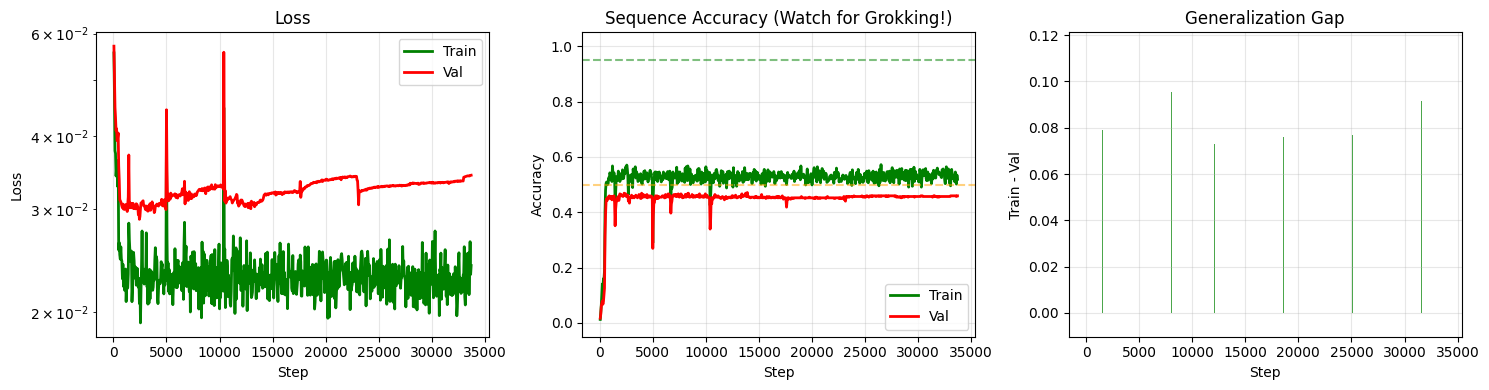

Step 33700: Train Seq Acc=51.9%, Val Seq Acc=45.9%


In [ ]:
# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
total_steps = len(train_loader) * NUM_EPOCHS
scheduler = CosineAnnealingLR(optimizer, T_max=total_steps, eta_min=1e-6)

print(f"Total steps: {total_steps}")
print(f"Training for {NUM_EPOCHS} epochs...")
print("="*50)

global_step = 0
best_val_acc = 0.0

for epoch in range(NUM_EPOCHS):
    model.train()
    
    for batch in train_loader:
        loss = compute_loss(model, batch, DEVICE)
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
        optimizer.step()
        scheduler.step()
        
        global_step += 1
        
        # Evaluate
        if global_step % EVAL_INTERVAL == 0:
            train_metrics = evaluate(model, train_loader, DEVICE, max_batches=20)
            val_metrics = evaluate(model, val_loader, DEVICE)
            plotter.log(global_step, train_metrics, val_metrics)
            
            if val_metrics['seq_acc'] > best_val_acc:
                best_val_acc = val_metrics['seq_acc']
                # Save best model
                torch.save(model.state_dict(), 'best_model.pt')
        
        # Plot
        if global_step % PLOT_INTERVAL == 0:
            plotter.plot()

print("\n" + "="*50)
print("Training complete!")
print(f"Best validation accuracy: {best_val_acc:.1%}")

## Cell 6: Final Results

In [ ]:
# Final plot
plotter.plot()

# Final eval
train_metrics = evaluate(model, train_loader, DEVICE)
val_metrics = evaluate(model, val_loader, DEVICE)

print("\n" + "="*50)
print("FINAL RESULTS")
print("="*50)
print(f"Train: Loss={train_metrics['loss']:.4f}, Seq Acc={train_metrics['seq_acc']:.1%}")
print(f"Val:   Loss={val_metrics['loss']:.4f}, Seq Acc={val_metrics['seq_acc']:.1%}")
print(f"\nBest Val Seq Acc: {best_val_acc:.1%}")

## Cell 7: Test Generation (Optional)

In [ ]:
# Test on a sample
model.eval()
sample = val_dataset[0]
input_ids = sample['input_ids'].unsqueeze(0).to(DEVICE)

# Find [ANSWER] position
answer_token_id = tokenizer.token_to_id['[ANSWER]']
answer_pos = (input_ids[0] == answer_token_id).nonzero()

if len(answer_pos) > 0:
    prompt_end = answer_pos[0].item() + 2
    prompt = input_ids[:, :prompt_end]
    
    generated = model.generate(prompt, max_new_tokens=20)
    
    print("=== INPUT ===")
    print(tokenizer.decode(prompt[0].tolist()))
    print("\n=== GENERATED ===")
    gen_part = generated[0, prompt_end:].tolist()
    print(tokenizer.decode(gen_part))
    print("\n=== EXPECTED ===")
    labels = sample['labels'].tolist()
    target_ids = [l for l in labels if l != -100 and l != tokenizer.pad_token_id]
    print(tokenizer.decode(target_ids))

## Cell 8: Download Model

In [ ]:
# Save and download
torch.save({
    'model_state_dict': model.state_dict(),
    'config': model_config,
    'history': plotter.history,
    'best_val_acc': best_val_acc,
}, 'trained_model.pt')

# Download (Colab only)
try:
    from google.colab import files
    files.download('trained_model.pt')
    print("Model downloaded!")
except:
    print("Model saved to trained_model.pt")